# Dual Momentum

Description

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import historic_cdi, historic_imab5, historic_sp500, STAR_DATE, END_DATE

### Importando os dados

In [2]:
IBOV = yf.Ticker('^BVSP')

ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [3]:
trading_days = ibov_prices.index.to_frame(index=False, name='Date')

In [4]:
cdi = historic_cdi(start=STAR_DATE, end=END_DATE)
imab5 = historic_imab5(start=STAR_DATE, end=END_DATE)
sp500_prices = historic_sp500(start=STAR_DATE, end=END_DATE, brl=True)

In [5]:
cdi_normalized = pd.merge(trading_days, cdi, left_on='Date', right_index=True, how='left').set_index('Date').squeeze()
imab5_normalized = pd.merge(trading_days, imab5, left_on='Date', right_index=True, how='left').set_index('Date').squeeze()

In [6]:
relative_prices = pd.merge(ibov_prices, sp500_prices, left_index=True, right_index=True, how='left')
relative_prices = (relative_prices / relative_prices.iloc[0])
relative_prices = relative_prices.set_axis(['IBOV', 'SP500 BRL'], axis=1)

relative_prices['SP500 BRL'] = relative_prices['SP500 BRL'].ffill()

In [7]:
prices = pd.concat([cdi, imab5, relative_prices['IBOV'], relative_prices['SP500 BRL']], keys=['CDI', 'IMA-B 5', 'IBOV', 'SP500 BRL'], join='inner', axis=1)
prices = (prices / prices.iloc[0])
prices = prices.dropna()

prices

,CDI,IMA-B 5,IBOV,SP500 BRL
2004-01-02,1.000000,1.000000,1.000000,1.000000
2004-01-05,1.000601,1.000576,1.048429,1.004152
2004-01-06,1.001202,1.001922,1.050390,1.001270
2004-01-07,1.001803,1.003517,1.038984,1.011210
2004-01-08,1.002405,1.007081,1.056672,1.011452
...,...,...,...,...
2024-09-05,8.225100,11.288138,6.081622,9.641519
2024-09-06,8.228330,11.287673,5.995634,9.416444
2024-09-09,8.231561,11.291618,6.002985,9.593035
2024-09-10,8.234794,11.287701,5.984406,9.662910


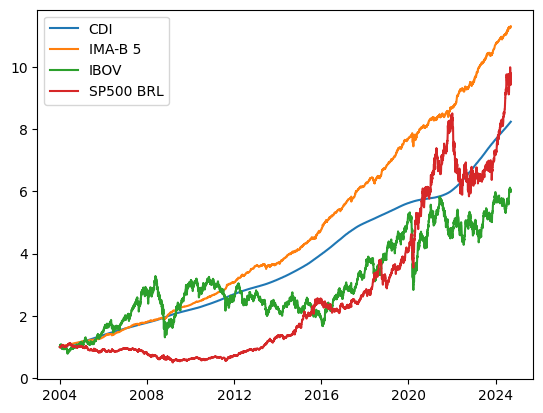

In [8]:
plt.plot(prices)
plt.legend(prices.columns)
plt.show()

In [32]:
ytd_returns = prices.pct_change(periods=252).dropna()

ytd_returns

,CDI,IMA-B 5,IBOV,SP500 BRL
2004-09-03,0.105229,0.121478,-0.001337,0.019509
2004-09-06,0.105213,0.121469,-0.043770,0.015294
2004-09-08,0.105198,0.120635,-0.044197,0.011047
2004-09-09,0.105183,0.119552,-0.044340,0.003485
2004-09-10,0.105168,0.117150,-0.073745,0.006825
...,...,...,...,...
2024-09-05,0.070729,0.049912,0.033926,0.342941
2024-09-06,0.070681,0.050062,0.016198,0.294633
2024-09-09,0.070634,0.050496,0.025029,0.318516
2024-09-10,0.070586,0.049962,0.026590,0.321610


In [33]:
time_series = pd.to_datetime(ytd_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

ytd_returns.loc[first_trading_day.values]

,CDI,IMA-B 5,IBOV,SP500 BRL
2004-09-03,0.105229,0.121478,-0.001337,0.019509
2004-10-01,0.105094,0.105162,0.062137,-0.026974
2004-11-01,0.105197,0.100635,0.034402,-0.034019
2004-12-01,0.105788,0.100223,0.172031,-0.018858
2005-01-03,0.108429,0.106095,0.294840,-0.024643
...,...,...,...,...
2024-05-02,0.078092,0.049105,0.086271,0.215011
2024-06-03,0.075979,0.058219,0.052681,0.286036
2024-07-01,0.074258,0.063363,0.096306,0.439006
2024-08-01,0.072604,0.061054,0.006773,0.386998


In [34]:
conditions = [
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']) & (ytd_returns['IBOV'] > ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']) & (ytd_returns['IBOV'] <= ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] <= ytd_returns['CDI']),
]

cases = ['IBOV', 'SP500 BRL', 'IMA-B 5']

ytd_returns['Investment'] = np.select(conditions, cases, default=None)
ytd_returns['Investment'] = ytd_returns['Investment'].ffill()

ytd_returns

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2004-09-03,0.105229,0.121478,-0.001337,0.019509,IMA-B 5
2004-09-06,0.105213,0.121469,-0.043770,0.015294,IMA-B 5
2004-09-08,0.105198,0.120635,-0.044197,0.011047,IMA-B 5
2004-09-09,0.105183,0.119552,-0.044340,0.003485,IMA-B 5
2004-09-10,0.105168,0.117150,-0.073745,0.006825,IMA-B 5
...,...,...,...,...,...
2024-09-05,0.070729,0.049912,0.033926,0.342941,IMA-B 5
2024-09-06,0.070681,0.050062,0.016198,0.294633,IMA-B 5
2024-09-09,0.070634,0.050496,0.025029,0.318516,IMA-B 5
2024-09-10,0.070586,0.049962,0.026590,0.321610,IMA-B 5


In [35]:
ytd_returns['Investment'].value_counts(normalize=True).round(2)

Investment
IMA-B 5      0.53
IBOV         0.37
SP500 BRL    0.09
Name: proportion, dtype: float64

In [36]:
dual_momentum = prices.pct_change().join(ytd_returns[['Investment']], how='right')

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2004-09-03,0.000586,0.000602,-0.012033,-0.006627,IMA-B 5
2004-09-06,0.000586,0.000567,0.003881,0.000000,IMA-B 5
2004-09-08,0.000587,0.000602,0.001422,-0.007041,IMA-B 5
2004-09-09,0.000587,0.000624,-0.011006,0.002374,IMA-B 5
2004-09-10,0.000587,0.001397,-0.014269,0.003569,IMA-B 5
...,...,...,...,...,...
2024-09-05,0.000393,0.001155,0.002873,-0.008502,IMA-B 5
2024-09-06,0.000393,-0.000041,-0.014139,-0.023344,IMA-B 5
2024-09-09,0.000393,0.000349,0.001226,0.018753,IMA-B 5
2024-09-10,0.000393,-0.000347,-0.003095,0.007284,IMA-B 5


In [37]:
dual_momentum['Dual Momentum'] = dual_momentum.apply(lambda row: row[row['Investment']], axis=1)
dual_momentum = dual_momentum.drop(columns=['Investment'])

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2004-09-03,0.000586,0.000602,-0.012033,-0.006627,0.000602
2004-09-06,0.000586,0.000567,0.003881,0.000000,0.000567
2004-09-08,0.000587,0.000602,0.001422,-0.007041,0.000602
2004-09-09,0.000587,0.000624,-0.011006,0.002374,0.000624
2004-09-10,0.000587,0.001397,-0.014269,0.003569,0.001397
...,...,...,...,...,...
2024-09-05,0.000393,0.001155,0.002873,-0.008502,0.001155
2024-09-06,0.000393,-0.000041,-0.014139,-0.023344,-0.000041
2024-09-09,0.000393,0.000349,0.001226,0.018753,0.000349
2024-09-10,0.000393,-0.000347,-0.003095,0.007284,-0.000347


In [39]:
dual_momentum_eval = (1 + dual_momentum).cumprod()
dual_momentum_eval = (dual_momentum_eval / dual_momentum_eval.iloc[0]) - 1

dual_momentum_eval

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2004-09-03,0.000000,0.000000,0.000000,0.000000,0.000000
2004-09-06,0.000586,0.000567,0.003881,0.000000,0.000567
2004-09-08,0.001173,0.001169,0.005309,-0.007041,0.001169
2004-09-09,0.001761,0.001794,-0.005755,-0.004684,0.001794
2004-09-10,0.002349,0.003194,-0.019942,-0.001132,0.003194
...,...,...,...,...,...
2024-09-05,6.441987,9.065410,5.089761,8.457019,13.793707
2024-09-06,6.444909,9.064996,5.003658,8.236251,13.793098
2024-09-09,6.447833,9.068514,5.011019,8.409463,13.798268
2024-09-10,6.450758,9.065021,4.992416,8.478001,13.793135


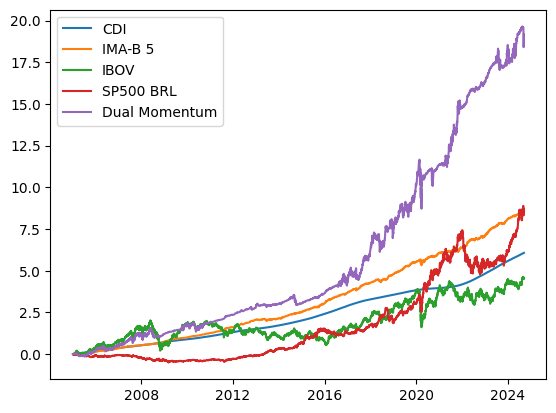

In [16]:
plt.plot(dual_momentum_eval)
plt.legend(dual_momentum_eval.columns)
plt.show()

In [17]:
dual_momentum_eval = dual_momentum_eval + 1
dual_momentum_eval.index = pd.to_datetime(dual_momentum_eval.index).date

series_start = dual_momentum_eval.index.min()
series_end = dual_momentum_eval.index.max()

years = (series_end - series_start).days / 365.25

avg_return = (dual_momentum_eval.iloc[-1] / (dual_momentum_eval.iloc[0])) ** (1 / years) - 1
avg_vol = dual_momentum.std() * (252 ** 0.5)

In [18]:
total_results = pd.concat([avg_return, avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)
total_results['Sharpe Ratio'] = (total_results['Avg Return'] - 0.10) / total_results['Avg Vol']

total_results

,Avg Return,Avg Vol,Sharpe Ratio
CDI,0.104512,0.002382,1.894436
IMA-B 5,0.121776,0.028581,0.761911
IBOV,0.090759,0.266199,-0.034714
SP500 BRL,0.122328,0.209224,0.106716
Dual Momentum,0.164932,0.161373,0.402371


### Benchmark

In [19]:
naive_portfolio = dual_momentum_eval[['IBOV', 'SP500 BRL', 'CDI', 'IMA-B 5']].mean(axis=1).rename('Naive Portfolio')
naive_portfolio.index = pd.to_datetime(naive_portfolio.index).date

naive_portfolio

2005-01-06    1.000000
2005-01-07    1.002108
2005-01-10    0.998013
2005-01-11    0.998825
2005-01-12    1.001604
                ...   
2024-09-05    7.948934
2024-09-06    7.874026
2024-09-09    7.920953
2024-09-10    7.933829
2024-09-11    7.971736
Name: Naive Portfolio, Length: 4873, dtype: float64

In [20]:
absolute_model = pd.read_csv('data/export_absolute_model.csv', index_col=0)
absolute_model.index = pd.to_datetime(absolute_model.index).date

In [21]:
relative_model = pd.read_csv('data/export_relative_model.csv', index_col=0)
relative_model.index = pd.to_datetime(relative_model.index).date

In [22]:
benchmark_models = [
    naive_portfolio,
    absolute_model['Return'] + 1,
    relative_model['Return'],
    dual_momentum_eval['Dual Momentum'],
]

benchmark = pd.concat(benchmark_models, keys=['Naive Portfolio', 'Absolute Momentum', 'Relative Momentum', 'Dual Momentum'], join='inner', axis=1)

benchmark

,Naive Portfolio,Absolute Momentum,Relative Momentum,Dual Momentum
2005-01-06,1.000000,1.000000,1.000000,1.000000
2005-01-07,1.002108,1.000042,1.015595,1.000042
2005-01-10,0.998013,1.000466,0.996922,1.000466
2005-01-11,0.998825,1.001055,1.000123,1.001055
2005-01-12,1.001604,1.001567,1.005869,1.001567
...,...,...,...,...
2024-09-03,7.936897,6.455563,16.431781,20.023440
2024-09-04,7.961925,6.540033,16.444839,20.039353
2024-09-05,7.948934,6.558820,16.305028,19.868981
2024-09-06,7.874026,6.466085,15.924396,19.405151


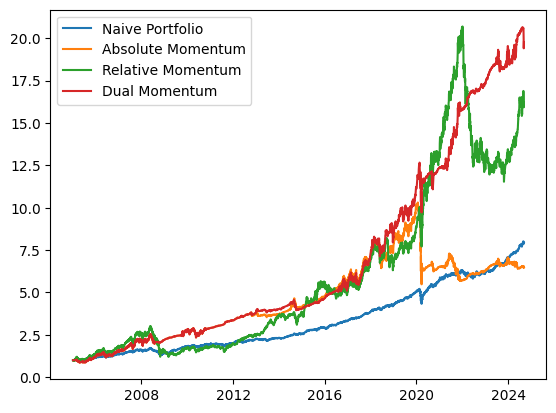

In [23]:
plt.plot(benchmark)
plt.legend(benchmark.columns)
plt.show()

In [24]:
series_start = benchmark.index.min()
series_end = benchmark.index.max()

years = (series_end - series_start).days / 365.25

benchmark_cagr = (benchmark.iloc[-1] / (benchmark.iloc[0])) ** (1 / years) - 1
benchmark_vol = benchmark.pct_change().std() * (252 ** 0.5)

In [25]:
total_results = pd.concat([benchmark_cagr, benchmark_vol], keys=['CAGR', 'Volatility'], axis=1)
total_results['Sharpe Ratio'] = (total_results['CAGR'] - 0.10) / total_results['Volatility']

total_results

,CAGR,Volatility,Sharpe Ratio
Naive Portfolio,0.110921,0.090697,0.120408
Absolute Momentum,0.099589,0.177445,-0.002317
Relative Momentum,0.152149,0.241278,0.216136
Dual Momentum,0.163784,0.161391,0.395215


In [26]:
benchmark_dd = (benchmark - benchmark.cummax()) / benchmark.cummax()

for col in benchmark_dd.columns:
    print(col, round(min(benchmark_dd[col]), 2) * 100, '%')

Naive Portfolio -27.0 %
Absolute Momentum -47.0 %
Relative Momentum -60.0 %
Dual Momentum -23.0 %
